In [1]:
import pandas as pd

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.style as style

In [3]:
train_df = pd.read_parquet('train.parquet')     #< ввод данных о клиентах
test_df = pd.read_parquet('test.parquet')

In [4]:
train_df.drop(["id", "target_1", "target_2", "branch_code", "index_city_code", "city"], axis=1, inplace=True) # Сброс лишних данных для создания модели

In [5]:
cat_cols = [
    'channel_code', 'city_type','okved',
    'ogrn_month', 'ogrn_year', 'segment'
]

In [6]:
train_df[cat_cols] = train_df[cat_cols].astype("category")      #обозначение катигорийных признаков

In [7]:
X = train_df.drop("total_target", axis=1)
y = train_df.total_target
x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,           #Указываем параметр цели, а так же разделяем данные на обучающий и тестовый набор.
                                                  random_state=42)

In [8]:
lgbm_tuned = LGBMClassifier(boosting_type = 'gbdt',
                            class_weight = None,
                            min_child_samples = 20,
                            num_leaves = 38,  #30
                            subsample_for_bin = 200, #20000
                            learning_rate=0.1,
                            max_depth=20,    #10
                            n_estimators=200,
                            colsample_bytree=0.2,
                            verbosity=-1,
                            random_state=42,
                            n_jobs=-1)
lgbm_tuned.fit(x_train, y_train)                                 # Настройка параметров мадели, и её обучение на обучающем наборе.


y_pred_tuned = lgbm_tuned.predict_proba(x_val)[:, 1]            # Валидация обученной модели на тестовом наборе.
roc_auc_score(y_val, y_pred_tuned)

0.8783618567037447

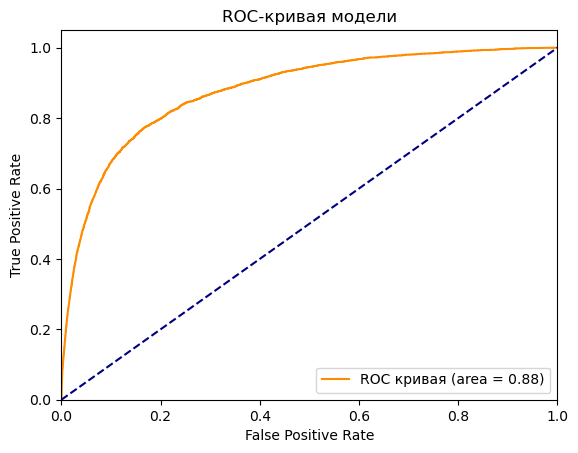

In [9]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, treshold = roc_curve(y_val, y_pred_tuned)              # строим график ROC-AUC
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)             
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели')
plt.legend(loc="lower right")
plt.show()

<Axes: xlabel='importance', ylabel='features'>

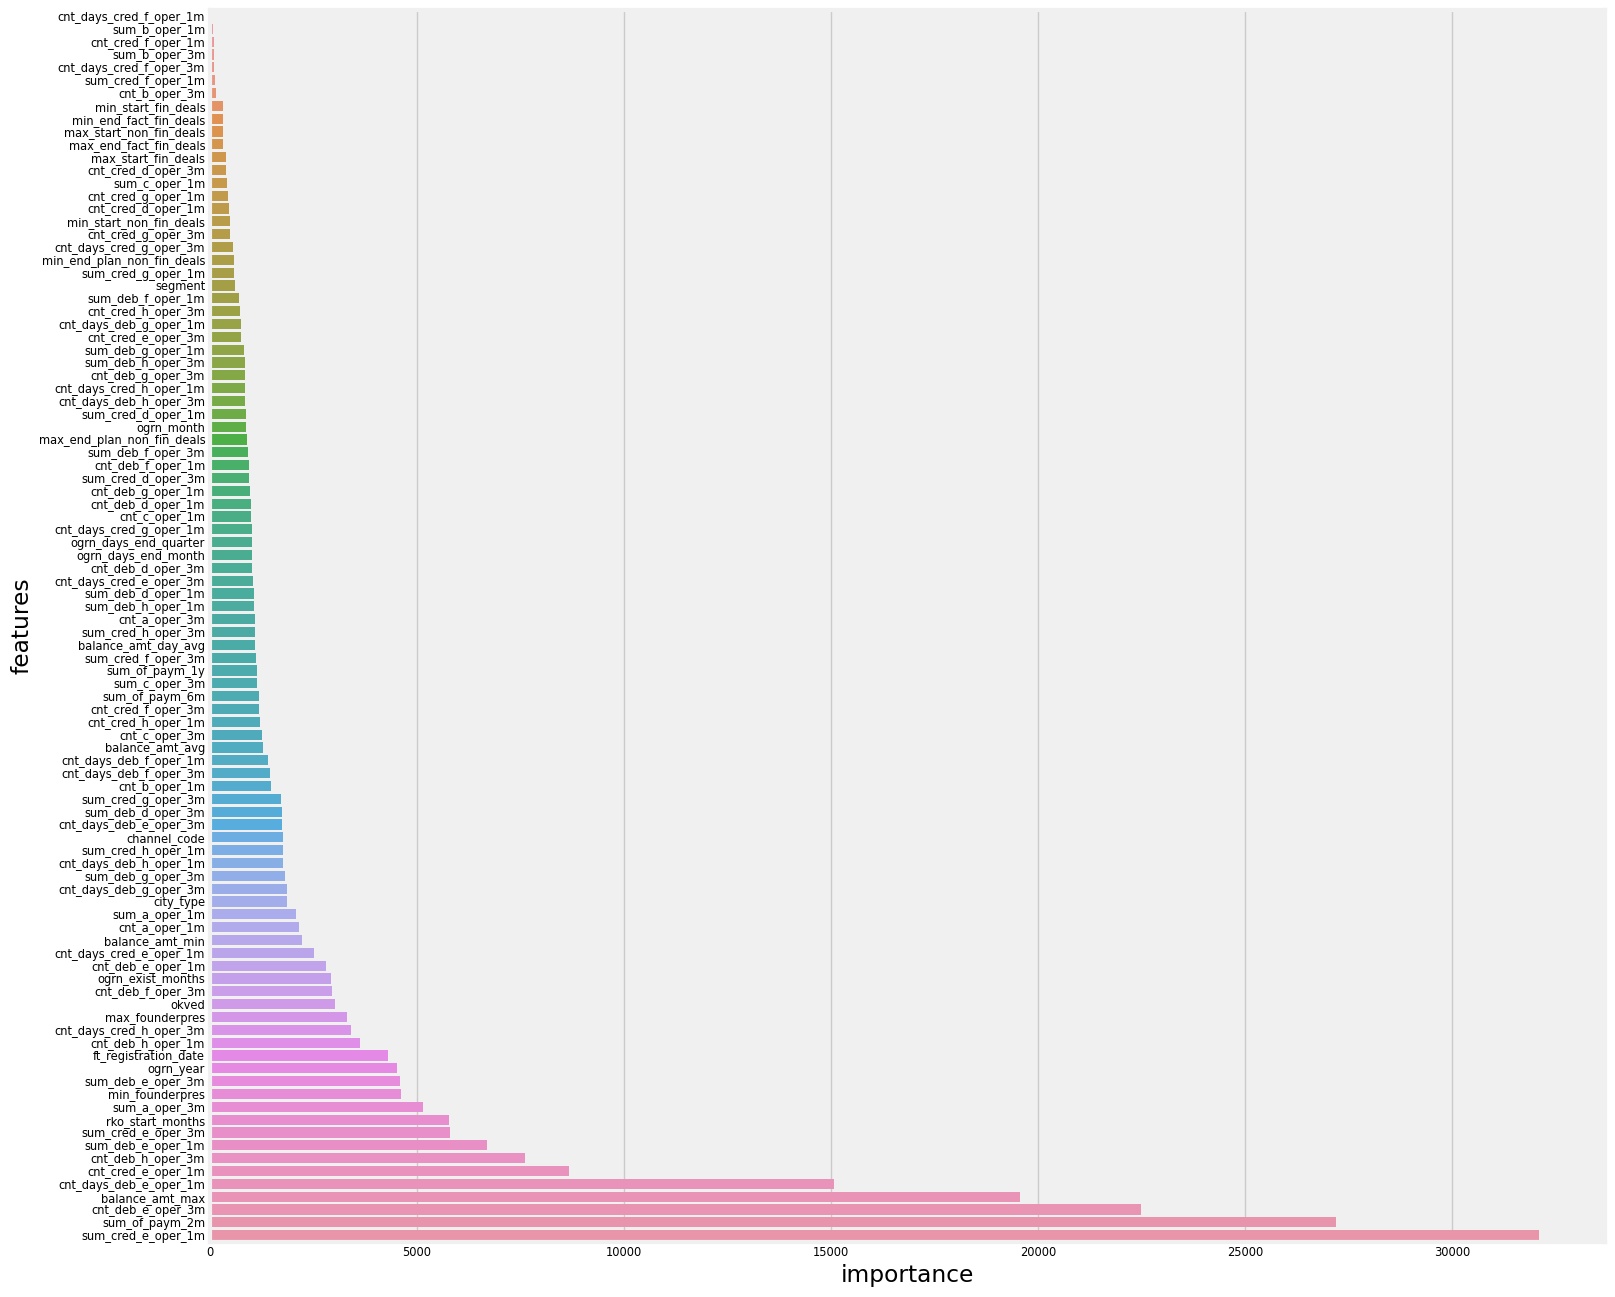

In [10]:
plt.figure(figsize=(18, 16))
sns.set_context("talk", font_scale=0.5, rc={"figure. figsize": (18, 16)})
style.use('fivethirtyeight')
fi = pd.DataFrame()
fi['features'] = X.columns.values.tolist()
fi['importance'] = lgbm_tuned.booster_.feature_importance(importance_type='gain')                          # Для наглядности можем посмотреть каким фичам модель придает большее значение.
sns.barplot(x='importance', y='features', data=fi.sort_values(by='importance', ascending=True))

Расчет предсказания для тестовых данных, и их вывод в файл

In [11]:
test_df[cat_cols] = test_df[cat_cols].astype("category")

In [12]:
test_score = lgbm_tuned.predict_proba(test_df.drop(["id", "branch_code", "index_city_code", "city" ], axis=1))[:, 1]

In [13]:
sample_submission_df = pd.read_csv("sample_submission.csv")

In [14]:
sample_submission_df["score"] = test_score

In [15]:
sample_submission_df.to_csv("my_submissionNEW22.csv", index=False)